In [1]:
import keras
import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed, Flatten
from keras.layers import LSTM, GRU, RNN
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from google.colab import files
# upload polution_dataSet.npy file
uploaded = files.upload()
# import data into a dataframe
import io
data = np.load(io.BytesIO(uploaded['polution_dataSet.npy']))

Saving polution_dataSet.npy to polution_dataSet (9).npy


In [0]:
'''
IN this part data for test, validation and train is preperd.
'''
# data format is : pollution  ,dew  ,temp  , press ,wnd_dir , wnd_spd , snow , rain
# total data =43000
# per day and week = 43000/24*7 =250

SAMPLE_DISTANCE = 24*7    # if 1 sample per hour, if 24 per day, if 24*7 per week
TRAIN_SIZE = 120
VAL_SIZE = 50
TEST_SIZE = 30
TIMESTEPS = 8             # timesteps used for a single prediction (here each timestep is a week)
HOUR = 2                  # which hour of day ? (0-23) (not so important)

In [0]:
x_train = []
y_train = []
for i in range(TRAIN_SIZE):
    x_train.append(np.array(data[i*SAMPLE_DISTANCE+HOUR:i*SAMPLE_DISTANCE+TIMESTEPS+HOUR]))
    y_train.append(np.array(data[i*SAMPLE_DISTANCE+TIMESTEPS+HOUR, 0]))
x_train = np.array(x_train)
y_train = np.array(y_train)

In [0]:
x_val = []
y_val = []
for i in range(TRAIN_SIZE, TRAIN_SIZE+VAL_SIZE):
    x_val.append(np.array(data[i*SAMPLE_DISTANCE+HOUR:i*SAMPLE_DISTANCE+TIMESTEPS+HOUR]))
    y_val.append(np.array(data[i*SAMPLE_DISTANCE+TIMESTEPS+HOUR, 0]))
x_val = np.array(x_val)
y_val = np.array(y_val)

In [0]:
x_test = []
y_test = []
for i in range(TRAIN_SIZE+VAL_SIZE, TRAIN_SIZE+VAL_SIZE+TEST_SIZE):
    x_test.append(np.array(data[i*SAMPLE_DISTANCE+HOUR:i*SAMPLE_DISTANCE+TIMESTEPS+HOUR]))
    y_test.append(np.array(data[i*SAMPLE_DISTANCE+TIMESTEPS+HOUR, 0]))
x_test = np.array(x_test)
y_test = np.array(y_test)
y_total = np.concatenate([y_train, y_val, y_test], axis=None)

In [0]:
'''
In this part network is implemented 
'''
# parameters
BATCH_SIZE = 10
NUM_EPOCHS = 20
HIDDEN_SIZE = 40

In [0]:
# class for RNN Keras
class MinimalRNNCell(keras.layers.Layer):

    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = units
        super(MinimalRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='uniform',
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer='uniform',
            name='recurrent_kernel')
        self.built = True

    def call(self, inputs, states):
        prev_output = states[0]
        h = K.dot(inputs, self.kernel)
        output = h + K.dot(prev_output, self.recurrent_kernel)
        return output, [output]

In [0]:
# Let's use this cell in a RNN layer:
cell = MinimalRNNCell(HIDDEN_SIZE)

In [0]:
K.clear_session()
# keras modeling
model = Sequential()
model.add(RNN(cell, input_shape=(TIMESTEPS, 8), return_sequences=False))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_1 (RNN)                  (None, 40)                1920      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 1,961
Trainable params: 1,961
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, verbose=1, validation_data=(x_val, y_val))

Train on 120 samples, validate on 50 samples
Epoch 1/20
120/120 [==============================] - 0s 2ms/step - loss: 0.0888 - val_loss: 0.0587
Epoch 2/20
120/120 [==============================] - 0s 233us/step - loss: 0.0600 - val_loss: 0.0696
Epoch 3/20
120/120 [==============================] - 0s 235us/step - loss: 0.0525 - val_loss: 0.0551
Epoch 4/20
120/120 [==============================] - 0s 227us/step - loss: 0.0464 - val_loss: 0.0545
Epoch 5/20
120/120 [==============================] - 0s 232us/step - loss: 0.0406 - val_loss: 0.0485
Epoch 6/20
120/120 [==============================] - 0s 231us/step - loss: 0.0345 - val_loss: 0.0345
Epoch 7/20
120/120 [==============================] - 0s 224us/step - loss: 0.0277 - val_loss: 0.0260
Epoch 8/20
120/120 [==============================] - 0s 246us/step - loss: 0.0199 - val_loss: 0.0201
Epoch 9/20
120/120 [==============================] - 0s 224us/step - loss: 0.0172 - val_loss: 0.0194
Epoch 10/20
120/120 [==================

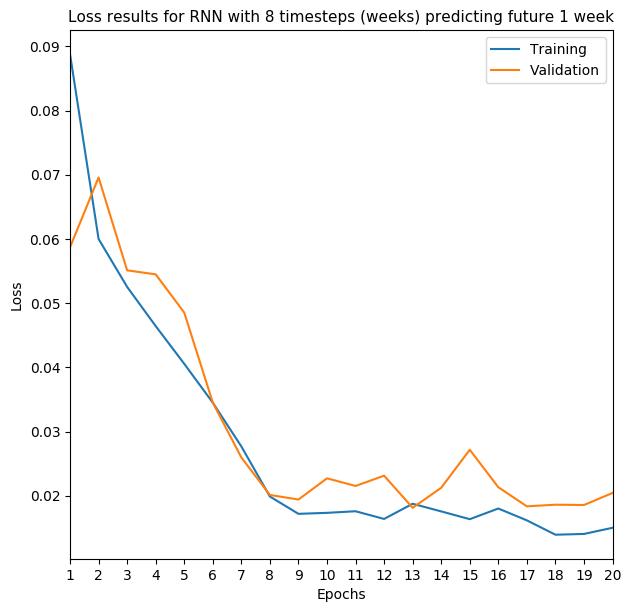

In [13]:
plt.figure(1, figsize=(7, 7), dpi=100)
plt.style.use(['default'])
plt.plot(np.arange(1,NUM_EPOCHS+1,1), history.history['loss'], label='Training')
plt.plot(np.arange(1,NUM_EPOCHS+1,1), history.history['val_loss'], label='Validation')
plt.xticks(np.arange(1, NUM_EPOCHS+1, 1, dtype=int))
plt.xlim(1, NUM_EPOCHS)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss results for RNN with 8 timesteps (weeks) predicting future 1 week', fontsize=11)
plt.legend()
plt.show()

In [14]:
print('train loss history:', history.history["loss"])
print('test loss history:', history.history["val_loss"])
scores = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1)
print('\nTest result loss: %.3f' % (scores))

train loss history: [0.08876430367430051, 0.05999739312877258, 0.05253636557608843, 0.046431177761405706, 0.04056016216054559, 0.03450692569216093, 0.02768843046699961, 0.01989315201838811, 0.017194970278069377, 0.01735113064448039, 0.01759711226137976, 0.016402158071286976, 0.01876454466643433, 0.017573736375197768, 0.016364597870657843, 0.01802266629723211, 0.0161802862615635, 0.013947018150550624, 0.01406399606882284, 0.015022759248192111]
test loss history: [0.05871446244418621, 0.06957620531320571, 0.055112534761428834, 0.05449003204703331, 0.04853324443101883, 0.034522615000605585, 0.025972823053598403, 0.020133677497506143, 0.01942180823534727, 0.02272504214197397, 0.021536916494369507, 0.02313631810247898, 0.01813413519412279, 0.021256761997938155, 0.02717256620526314, 0.021340078115463255, 0.018364665284752845, 0.018616478145122527, 0.018571188673377037, 0.020447273552417756]
30/30 [==============================] - 0s 516us/step

Test result loss: 0.015


In [0]:
y_train = model.predict(x_train, batch_size=BATCH_SIZE)
y_val = model.predict(x_val, batch_size=BATCH_SIZE)
y_pred = model.predict(x_test, batch_size=BATCH_SIZE)

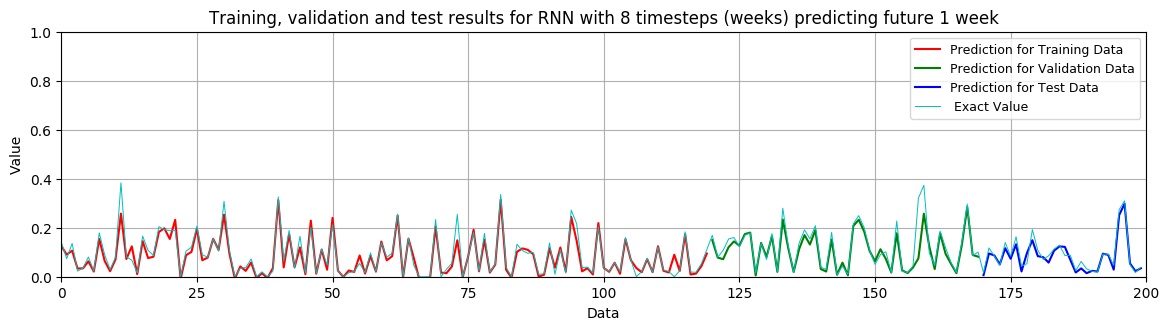

In [16]:
plt.figure(2, figsize=(14, 7), dpi=100)
plt.style.use(['default'])
plt.subplot(211)
plt.plot(range(0, TRAIN_SIZE), y_train, c='r', linewidth=1.5, label='Prediction for Training Data')
plt.plot(range(TRAIN_SIZE, TRAIN_SIZE+VAL_SIZE), y_val, c='g', linewidth=1.5, label='Prediction for Validation Data')
plt.plot(range(TRAIN_SIZE+VAL_SIZE, TRAIN_SIZE+VAL_SIZE+TEST_SIZE), y_pred, c='b', linewidth=1.5, label='Prediction for Test Data')
plt.plot(range(0, TRAIN_SIZE+VAL_SIZE+TEST_SIZE), y_total, c='c', linewidth=0.7, label=' Exact Value')
plt.xlim(0, TRAIN_SIZE+VAL_SIZE+TEST_SIZE)
plt.ylim(0, 1)
plt.xlabel('Data')
plt.ylabel('Value')
plt.title('Training, validation and test results for RNN with 8 timesteps (weeks) predicting future 1 week')
plt.legend(loc='best', fontsize=9)
plt.grid(True)
plt.show()

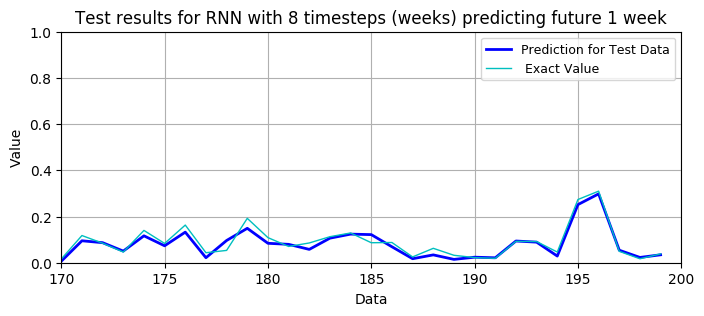

In [17]:
plt.figure(3, figsize=(8, 3), dpi=100)
plt.style.use(['default'])
plt.plot(range(TRAIN_SIZE+VAL_SIZE, TRAIN_SIZE+VAL_SIZE+TEST_SIZE), y_pred, 'b', linewidth=2, label='Prediction for Test Data')
plt.plot(range(TRAIN_SIZE+VAL_SIZE, TRAIN_SIZE+VAL_SIZE+TEST_SIZE), y_total[TRAIN_SIZE+VAL_SIZE:TRAIN_SIZE+VAL_SIZE+TEST_SIZE], c='c', linewidth=1, label=' Exact Value')
plt.xlim(TRAIN_SIZE+VAL_SIZE, TRAIN_SIZE+VAL_SIZE+TEST_SIZE)
plt.ylim(0, 1)
plt.xlabel('Data')
plt.ylabel('Value')
plt.title('Test results for RNN with 8 timesteps (weeks) predicting future 1 week')
plt.grid(True)
plt.legend(loc='best', fontsize=9)
plt.show()